# Quantum Algorithms for Machine Learning

What do we mean when we talk about *quantum machine learning*? Und this term, algorithms and procedures are grouped that use quantum computation and quantum algorithms to speed up machine learning processes or parts of machine learning algorithms on a quantum computer.

To faciliate machine learning on a quantum computer, we will here take the approach of using quantum algorithms to speed up the underlying linear algebraic calculations done in machine learning algorithms. 

In order to process the vectors and matrices on the quantum computer, they have to be encoded into quantum states. Efficient encodings can achieve an exponential compression. A vector $\vec a \in \mathbb C^n$ can be encoded with $\mathcal O (\log n)$ qubits. Algorithms to encode these linear algebraic constucts into quantum memory are possible in $\mathcal O(\mathrm{polylog} (n))$, that is polynomic in the encoding size.

The possible physical realization of QRAM with qutrits (three-level quantum states), was described by Giovanetti et. al. in 2007.

The speed of the encoding algorithm depends on the memory model used by the quantum memory. There are suggested designs of quantum memories with classical memory, where encoding takes $\mathcal O(n)$ steps since every bit has to be accessed individually. Quantum memories with a quantum memory component allow polylog encoding.

## Quantum Bits

In [1]:
%matplotlib inline

import numpy as np
import numpy.linalg as lg
import numpy.random as random
import matplotlib.pyplot as plt

7
000 => 0.71+0.00j
001 => 0.00+0.00j
010 => 0.71+0.00j
011 => 0.00+0.00j
000 => 0.41+0.00j
001 => 0.58+0.00j
010 => 0.41+0.00j
011 => 0.58+0.00j


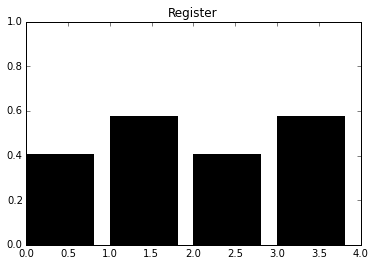

In [14]:
class QuantumRegister(object):
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.n_states = 2 ** n_qubits
        self.qubits = np.zeros((self.n_states), dtype=complex)
        self.qubits[0] = 1.0
        
    def isset(self, state, n):
        return state & 1<<(self.n_qubits-1-n) != 0
    
    def flip(self, state, n):
        return state ^ 1<<(self.n_qubits-1-n)
    
    def set_qubit(self, n, a, b): # a|0>+b|1>
        tmp_qubits = np.zeros((self.n_states), dtype=complex)
        for state in range(self.n_states):
            current_amplitude = self.qubits[state] + self.qubits[self.flip(state,n)]
            if self.isset(state, n):
                tmp_qubits[state] = current_amplitude*b
            else:
                tmp_qubits[state] = current_amplitude*a
        self.qubits = tmp_qubits
    
    def measure(self):
        probabilities = np.absolute(self.qubits)**2
        return random.choice(len(probabilities), p=probabilities.flatten())
        
    def hadamar(self):
        hadamar = np.zeros((self.n_states, self.n_states))
        for target in range(self.n_states):
            for state in range(self.n_states):
                hadamar[target, state] = (2.**(-self.n_qubits/2.))*(-1)**bin(state & target).count("1")
        self.qubits = hadamar.dot(self.qubits)
        return self
    
    def __str__(self):
        string = ""
        for state in range(self.n_states):
            string += "{0:0>3b}".format(state) + " => {:.2f}".format(self.qubits[state]) + "\n"
        return string[:-1]
    
    def plot(self):
        plt.bar(range(self.n_states), np.absolute(self.qubits), color='k')
        plt.title('Register')
        plt.axis([0,self.n_states,0.0,1.0])
        plt.show()
        
register = QuantumRegister(3)
register.hadamar()
print register.measure()

register = QuantumRegister(2)
register.set_qubit(0, 1/np.sqrt(2), 1/np.sqrt(2))
print register
register.set_qubit(1, 1/np.sqrt(3), np.sqrt(2./3.))
print register

register.plot()

## Grover search

12.5663706144 cycles


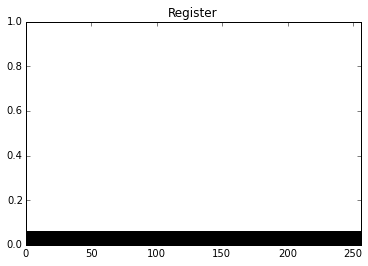

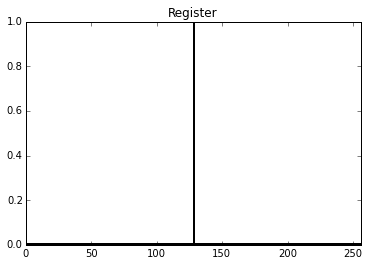

128


In [15]:
class GroverRegister(QuantumRegister):
    def conditional_phase_shift(self):
        for state in range(1,self.n_states):
            self.qubits[state] = -1 * self.qubits[state]
        return self

    def oracle(self):
        correct_state = 128
        self.qubits[correct_state] = -1 * self.qubits[correct_state]
        return self
    
register = GroverRegister(8)
register.hadamar()

cycles = np.pi/4*np.sqrt(2**register.n_qubits)
print cycles, 'cycles'
register.plot()
for i in range(int(np.round(cycles))):
    register.oracle().hadamar().conditional_phase_shift().hadamar()
register.plot()
print register.measure()

## Quantum Memory: qRAM

In random access memory, a randomly selected memory cell can be selected at will. The RAM takes the address of the cell as input (in the input register) and returns the contents of the cell (into the output register). Quantum random access memory, *qRAM*, is the quantum analog of traditional RAM required for large-scale quantum computers. QRAM supports superposition access to memory cells. If the input register holds a superposition of cells, the quantum memory will return a superposition of states as well. $\newcommand{\ket}[1]{\left|{#1}\right\rangle} \newcommand{\bra}[1]{\left\langle{#1}\right|}$

$$ \sum _j \psi _j \ket{j} _a \rightarrow \sum _j \psi _j \ket{j}_a \ket{D_j}_d $$

with address register $a$, data register $d$ and $D_j$ the content of the $j$th memory cell. 

Use cases for qRAM: Quantum random access memory is required for quantum Fourier transforms and quantum searches over classical data, therefore rendering them irreplaceable for quantum machine learning appliations.

### The cost of access

For traditional RAM, stored in a one-dimensional lattice, access to the memory requires $\mathcal O (N)$ interactions, where $N = 2^n$ is the number of memory slots and $n$ is the number of bits of the address register. A qRAM architecture based on so-called *bucket brigades* suggested by Giovannetti, Lloyd and Maccone achieves the retrieval of quantum informaion out of the memory in only $\mathcal O (\log N)$ steps.

### Simulating qRAM

To simulate a quantum computer, the quantum random access memory will be implemented. The required size of the access register $a$ depends on the maximum number of (qu)bits $N$ stored in the quantum memory. The access register needs to be of size $n = \log _2 N$. Equivalently, a data register $d$ of size $m$ can store $M = 2^m$ data points.

In [10]:
import numpy as np

class QRam(object):
    def __init__(self, accessQubits, dataQubits): 
        self.accessQubits = accessQubits
        self.dataQubits = dataQubits

        self.accessStates = 2 ** accessQubits
        self.dataStates = 2 ** dataQubits
        
        self.memory = np.zeros((self.accessStates, self.dataStates), dtype=complex)
        
    def retrieve(self, access): 
        out = np.zeros((self.dataStates,), dtype=complex)
        for i in range(access.shape[0]):
            out += access[i] ** 2 * self.memory[i,:]
        return out
    
    def store(self, access, data):
        assert access < self.accessStates
        self.memory[access,:] = data

qram = QRam(2, 3)

qram.store(0, np.array([1., 0., 0., 0., 0., 0., 0., 0.]))
qram.store(1, np.array([0., 1., 0., 0., 0., 0., 0., 0.]))

print qram.retrieve(np.array([1., 0.,]))
print qram.retrieve(np.array([1./np.sqrt(2), 1./np.sqrt(2)]))

[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
[ 0.5+0.j  0.5+0.j  0.0+0.j  0.0+0.j  0.0+0.j  0.0+0.j  0.0+0.j  0.0+0.j]


What are the advantages of qRAM? Take for example an $N$ dimensional complex vector. Only $\log_2 N$ qubits are required for storing this vector in qRAM. The information is stored in the complex amplitudes of the state space of the vector. These are exponentially compressed quantum representations of the state vectors.

Data in the quantum random access memory can by quantum algorithms be accessed in quantum parallel. The data can now be post-processed e.g. by using quantum Fourier transformation, matrix inversion or else. The creation of $QFT\ket{v}$ or $f(A)\ket{v}$ ($A$ a sparse Hermitian matrix, $f$ e.g. $f(A) = A^{-1}$). This post-processing takes $\mathcal O (\mathrm{poly} (\log N))$ steps compared to classically necessary $\mathcal O(\mathrm{poly} N)$ steps.

## Linear Algebra Algorithms

### Inner Product $\vec v \cdot \vec w$

Using the controlled swap algorithm, the inner product of two vector $\vec v \cdot \vec w$ can be estimated. The vectors are stored in quantum memory.

Retrieve from qRAM the vectors $v$ and $w$ in a superposition and do a Hadamar transform.

$$ (\alpha \ket{0,x_0} + \beta \ket{1,x_1} ) \rightarrow \frac{1}{\sqrt 2} (\ket{0}\ket{\alpha x_0 + \beta x_1} + \ket{1}\ket{\alpha x_0 - \beta x_1} ) $$

The standard swap tests uses $\alpha = \beta = \frac{1}{2}$, therefore we can measure the state $\ket{0}$ with probability $(1+\bra{x_0}\ket{x_1}^2) / 2$

#### Proof

still missing...

## General swap test

In [31]:
class SwapRegister(QuantumRegister):
    def cswap(self, c, a, b):
        cswap = np.zeros((self.n_states, self.n_states))
        for state in range(self.n_states):
            if self.isset(state, c): 
                if self.isset(state, a) != self.isset(state,b):
                    flipstate = self.flip(self.flip(state, b), a)
                    cswap[state, flipstate] = 1.0
                else:
                    cswap[state, state] = 1.0
            else:
                cswap[state, state] = 1.0
        self.qubits = cswap.dot(self.qubits)
        return self
    
register = SwapRegister(3)
register.qubits = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
print register
register.cswap(1,0,2)
print register

000 => 1.00
001 => 2.00
010 => 3.00
011 => 4.00
100 => 5.00
101 => 6.00
110 => 7.00
111 => 8.00
000 => 1.00
001 => 2.00
010 => 3.00
011 => 7.00
100 => 5.00
101 => 6.00
110 => 4.00
111 => 8.00


In [21]:
class DotProductRegister(SwapRegister):
    def dot(self):
        pass
    
register = DotProductRegister(5)
qram = QRam(1,2)
qram.store(0, np.array([1./np.sqrt(2), 1./np.sqrt(2),0,0]))
qram.store(1, np.array([1./np.sqrt(3), np.sqrt(2./3.),0,0]))

print qram.retrieve(np.array([1./np.sqrt(2), 1./np.sqrt(2)]))

[ 0.64222853+0.j  0.76180168+0.j  0.00000000+0.j  0.00000000+0.j]


In [18]:
v = np.array([1/np.sqrt(2), 1/np.sqrt(2)]) # (1/sqrt(2), 1/sqrt(2))
w = np.array([1/np.sqrt(3), np.sqrt(2./3.)]) # (1/sqrt(3), sqrt(2/3))
print v,w
qstate = np.array([v[0]*w[0], v[0]*w[1], v[1]*w[0], v[1]*w[1]])
print qstate
print v.dot(w)

[ 0.70710678  0.70710678] [ 0.57735027  0.81649658]
[ 0.40824829  0.57735027  0.40824829  0.57735027]
0.985598559653


In [34]:
# https://www.cs.ucsb.edu/~vandam/teaching/S05_CS290/week9.pdf

register = SwapRegister(3)
#register.qubits[0:4] = np.array([1./np.sqrt(6), 1./np.sqrt(6), 1./np.sqrt(3), 1./np.sqrt(3)])
register.set_qubit(1, 1/np.sqrt(2), 1/np.sqrt(2))
register.set_qubit(2, 1/np.sqrt(3), np.sqrt(2./3.))
print "Initial"
print register
H = 1./np.sqrt(2) * np.array([[1., 1.],[1., -1.]])
eye = np.eye(2)
H_t = np.kron(H,np.kron(eye,eye))

register.qubits = H_t.dot(register.qubits)
print "Hadamar"
print register
register.cswap(0,1,2)
print "c-swap"
print register
register.qubits = H_t.dot(register.qubits)
print "Hadamar"
print register

def avg(values):
    return sum(values)/float(len(values))
average = avg([register.measure() < 4 for i in range (10000)])
#print average
print "Measure average"
print np.sqrt(average*2-1)

Initial
000 => 0.41+0.00j
001 => 0.58+0.00j
010 => 0.41+0.00j
011 => 0.58+0.00j
100 => 0.00+0.00j
101 => 0.00+0.00j
110 => 0.00+0.00j
111 => 0.00+0.00j
Hadamar
000 => 0.29+0.00j
001 => 0.41+0.00j
010 => 0.29+0.00j
011 => 0.41+0.00j
100 => 0.29+0.00j
101 => 0.41+0.00j
110 => 0.29+0.00j
111 => 0.41+0.00j
c-swap
000 => 0.29+0.00j
001 => 0.41+0.00j
010 => 0.29+0.00j
011 => 0.41+0.00j
100 => 0.29+0.00j
101 => 0.29+0.00j
110 => 0.41+0.00j
111 => 0.41+0.00j
Hadamar
000 => 0.41+0.00j
001 => 0.49+0.00j
010 => 0.49+0.00j
011 => 0.58+0.00j
100 => 0.00+0.00j
101 => 0.08+0.00j
110 => -0.08+0.00j
111 => 0.00+0.00j
Measure average
0.985900603509
